## Compare SVC in the case of binary class (Sell, Buy)

In [89]:
import sys
import os
from pathlib import Path

import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from utility_functions import (
    backtest_strategy,
    display_report,
    objective_svc,
    plot_strategy,
    select_threshold,
)

In [90]:
metric = "precision"
test_size = 300

In [91]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [92]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [93]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [94]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [95]:
interest_rate = wk_df["r"].values

## Baseline SVC Classifier without new data + r

In [96]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [97]:
orig_df["r"] = interest_rate

### Split dataset

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [99]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=2024, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_svc(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=600,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-13 22:59:57,357] A new study created in memory with name: no-name-9cd34871-abdb-44e1-af88-e0bc574d1923


[I 2024-02-13 23:00:00,347] Trial 0 finished with value: 0.5405032656841983 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 31.452426512790613, 'gamma': 'scale', 'shrinking': False}. Best is trial 0 with value: 0.5405032656841983.
[I 2024-02-13 23:00:03,023] Trial 1 finished with value: 0.5452637132997921 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 54.53613113150663, 'gamma': 'scale', 'shrinking': False}. Best is trial 1 with value: 0.5452637132997921.
[I 2024-02-13 23:00:03,268] Trial 2 finished with value: 0.5686126332777406 and parameters: {'kernel': 'sigmoid', 'degree': 3, 'C': 0.018080931691838945, 'gamma': 'auto', 'shrinking': True}. Best is trial 2 with value: 0.5686126332777406.
[I 2024-02-13 23:00:03,526] Trial 3 finished with value: 0.5446015918942186 and parameters: {'kernel': 'sigmoid', 'degree': 8, 'C': 0.02939778761268491, 'gamma': 'auto', 'shrinking': True}. Best is trial 2 with value: 0.5686126332777406.
[I 2024-02-13 23:00:03,782] Trial 4 finished with va

Number of finished trials: 150
Best trial:
  Value: 0.5983115072921132
  Params: 
    kernel: rbf
    degree: 8
    C: 97.66047155549107
    gamma: scale
    shrinking: False


In [100]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        (
            "clf",
            SVC(**trial.params | {"random_state": 1968, "probability": True}),
        ),
    ]
)

In [101]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('clf',
                 SVC(C=97.66047155549107, degree=8, probability=True,
                     random_state=1968, shrinking=False))])

In [102]:
# In-sample score
pipe.score(X_train, y_train)

0.7335069444444444

In [103]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=0.05)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.63


In [104]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [105]:
pipe.score(X_test, y_test)

0.52

              precision    recall  f1-score   support

           0       0.56      0.81      0.66       170
           1       0.41      0.18      0.25       130

    accuracy                           0.53       300
   macro avg       0.49      0.49      0.45       300
weighted avg       0.50      0.53      0.48       300



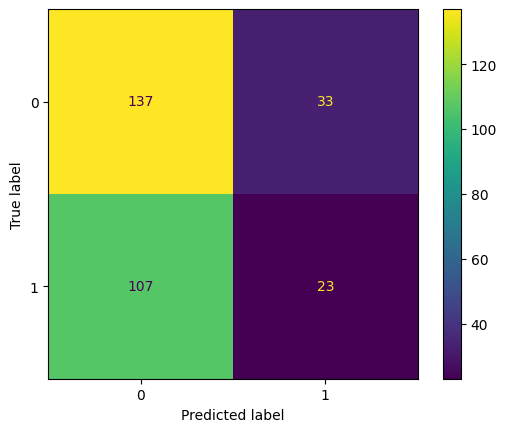

In [106]:
display_report(y_test, predictions)

In [107]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [108]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [109]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.0,-7.580000,0.000000,-7.580000
2022-08-05,0,413.0,7.66,2022-08-26,405.309998,0.0,-7.660000,0.000000,-15.240000
2022-08-08,0,413.0,7.44,2022-08-29,402.630005,0.0,-7.440000,0.000000,-22.680000
2022-08-09,0,411.0,7.51,2022-08-29,402.630005,0.0,-7.510000,0.000000,-30.190000
2022-08-10,0,420.0,6.90,2022-08-31,395.179993,0.0,-6.900000,0.000000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.0,-2.390007,-0.449967,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,-0.449967,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,-0.449967,126.819912


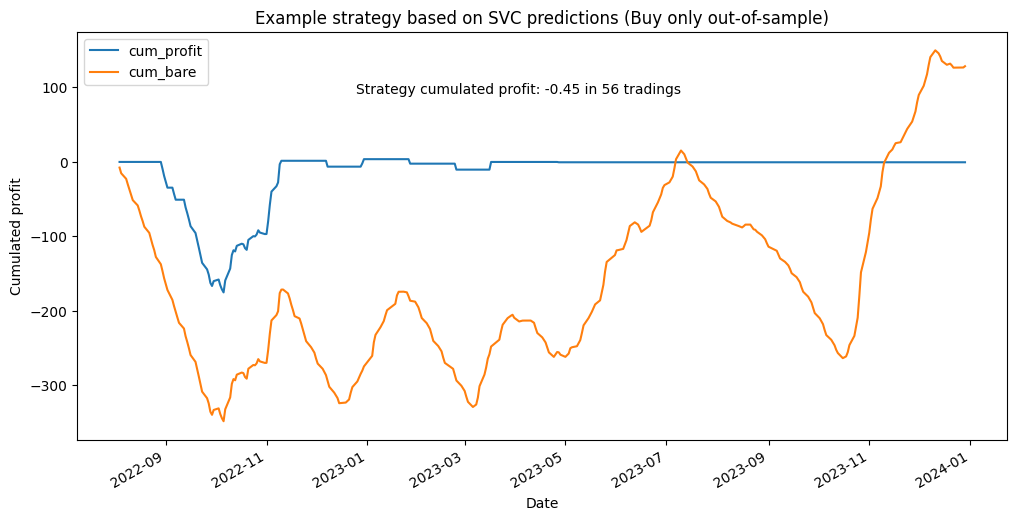

In [110]:
plot_strategy(strategy_df, "SVC", "(Buy only out-of-sample)")

In [111]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## SVC with data from MC simulation and additional features

In [112]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [113]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [115]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_svc(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=1200,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-13 23:01:55,806] A new study created in memory with name: no-name-ac18904f-c1d6-47c0-b1fe-860b325b1562
[I 2024-02-13 23:01:57,093] Trial 0 finished with value: 0.5522008893138983 and parameters: {'kernel': 'poly', 'degree': 6, 'C': 58.246152254253985, 'gamma': 'auto', 'shrinking': False}. Best is trial 0 with value: 0.5522008893138983.
[I 2024-02-13 23:01:58,143] Trial 1 finished with value: 0.5606420569478472 and parameters: {'kernel': 'poly', 'degree': 6, 'C': 88.76782521053377, 'gamma': 'auto', 'shrinking': False}. Best is trial 1 with value: 0.5606420569478472.
[I 2024-02-13 23:01:58,416] Trial 2 finished with value: 0.5248274647044822 and parameters: {'kernel': 'poly', 'degree': 5, 'C': 0.010942849369889686, 'gamma': 'auto', 'shrinking': False}. Best is trial 1 with value: 0.5606420569478472.
[I 2024-02-13 23:01:58,916] Trial 3 finished with value: 0.642144560637172 and parameters: {'kernel': 'rbf', 'degree': 2, 'C': 76.0380640670177, 'gamma': 'scale', 'shrinking': True

Number of finished trials: 150
Best trial:
  Value: 0.644942061478106
  Params: 
    kernel: rbf
    degree: 3
    C: 79.70095027013298
    gamma: scale
    shrinking: True


In [116]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        (
            "clf",
            SVC(**study.best_params | {"random_state": 1968, "probability": True}),
        ),
    ]
)

In [117]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('clf',
                 SVC(C=79.70095027013298, probability=True,
                     random_state=1968))])

In [118]:
# In-sample score
pipe.score(X_train, y_train)

0.8046875

In [119]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=0.05)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.63


In [120]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [121]:
pipe.score(X_test, y_test)

0.49666666666666665

              precision    recall  f1-score   support

           0       0.77      0.24      0.36       170
           1       0.48      0.91      0.62       130

    accuracy                           0.53       300
   macro avg       0.62      0.57      0.49       300
weighted avg       0.64      0.53      0.47       300



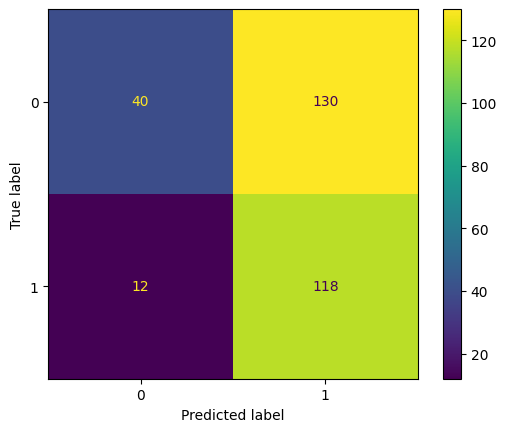

In [122]:
display_report(y_test, predictions)

In [123]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [124]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [125]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.00,-7.580000,0.000000,-7.580000
2022-08-05,0,413.0,7.66,2022-08-26,405.309998,0.00,-7.660000,0.000000,-15.240000
2022-08-08,1,413.0,7.44,2022-08-29,402.630005,-7.44,-7.440000,-7.440000,-22.680000
2022-08-09,0,411.0,7.51,2022-08-29,402.630005,0.00,-7.510000,-7.440000,-30.190000
2022-08-10,1,420.0,6.90,2022-08-31,395.179993,-6.90,-6.900000,-14.340000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.00,-2.390007,335.669963,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.00,-3.020007,335.669963,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.00,0.239993,335.669963,126.819912


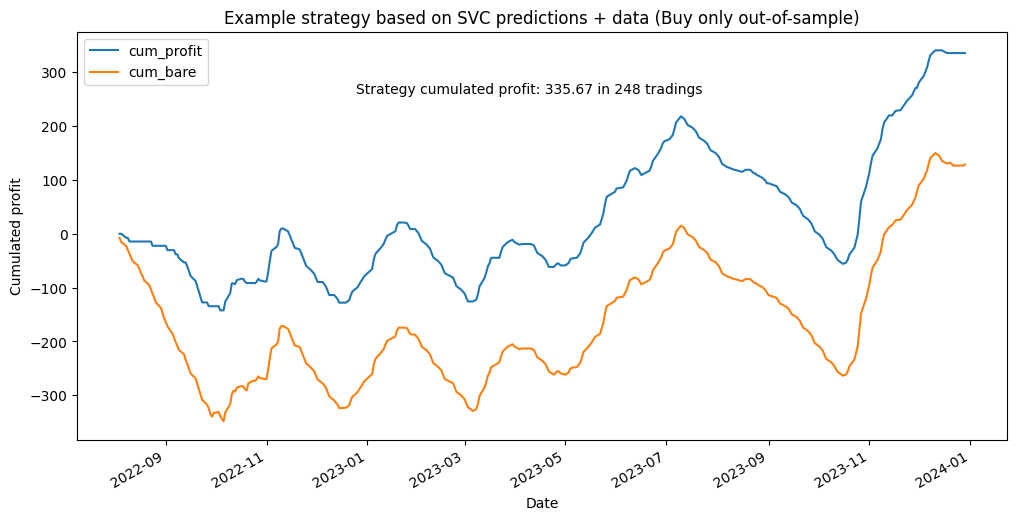

In [126]:
plot_strategy(strategy_df, "SVC", "+ data (Buy only out-of-sample)")

In [127]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [128]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [129]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
2,0,0.000000,1,-7.440000,-22.680000
4,0,0.000000,1,-14.340000,-37.090000
14,0,0.000000,1,-22.280000,-111.430000
18,1,-9.100000,0,-22.280000,-146.440000
19,1,-18.870000,0,-22.280000,-156.210000
...,...,...,...,...,...
286,0,-0.449967,1,308.629971,117.719949
287,0,-0.449967,1,320.889968,129.979946
288,0,-0.449967,1,331.639966,140.729944
289,0,-0.449967,1,340.749963,149.839941


In [130]:
compare_df[mask_out].shape

(222, 5)

In [131]:
compare_df.sum(axis=0)

bare_rf_pred_out          56.000000
cum_profit_out         -5172.612808
mmar_rf_pred_out         248.000000
mmar_cum_profit_out     7259.836300
mmar_cum_bare_out     -49180.449390
dtype: float64

<Axes: title={'center': 'Stategy comparison'}, ylabel='Profit'>

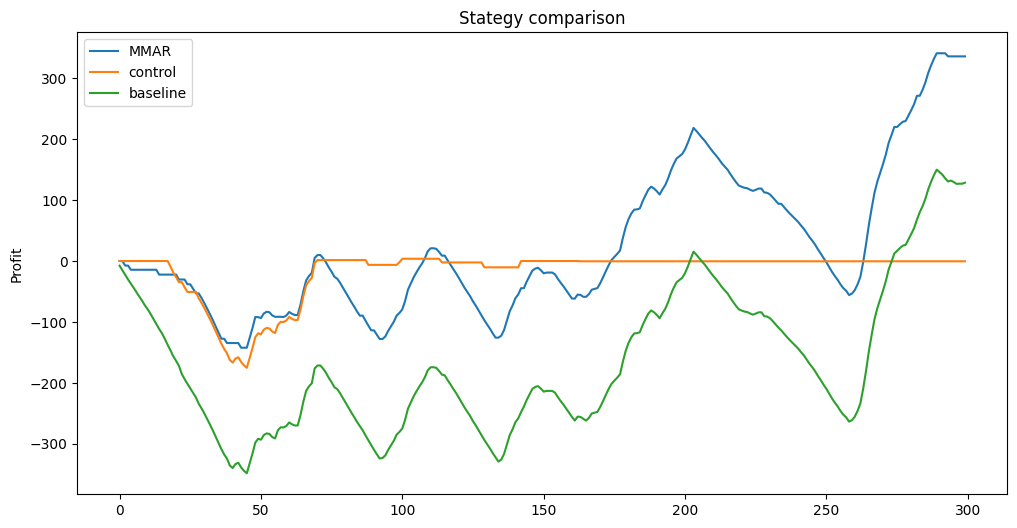

In [132]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")